## Model Fitting using HMC (Stan)

This code implements model fitting to data using Hamiltonian Monte Carlo (HMC).

For this code to run, you need to install PyStan (Python interface for Stan) first. See an installation guide at https://mc-stan.org/users/interfaces/pystan.html.

In [1]:
import numpy as np
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as sio
import pystan #Python interface for Stan (Stan implements Hamiltonian Monte Carlo)

In [3]:
#Load the data from .mat files corresponding to 3 experiments done at 3 different strain fraction pairs (r_x, r_y)
Data_fixZ = sio.loadmat('fixZ_varyXtoY.mat')
num_tps=len(Data_fixZ['all_flu'][:,0,0,0,0])
tps=np.array(range(0,num_tps*10,10))

#first experiment
day=0 
whichRatio=2 #3rd ratio
OD_allreps=np.zeros([num_tps,6])
F1_allreps=np.zeros([num_tps,6])
F2_allreps=np.zeros([num_tps,6])
F3_allreps=np.zeros([num_tps,6])
for repl in range(6):
    OD=Data_fixZ['all_od'][:,repl,whichRatio,day] 
    F1=Data_fixZ['all_flu'][:,repl,whichRatio,0,day]
    F2=Data_fixZ['all_flu'][:,repl,whichRatio,1,day]
    F3=Data_fixZ['all_flu'][:,repl,whichRatio,2,day]
    F1=F1-np.mean(F1[0:11]) #to get rid of the initial noise (before induction)
    F2=F2-np.mean(F2[0:11])
    F3=F3-np.mean(F3[0:11])
    OD_allreps[:,repl]=OD
    F1_allreps[:,repl]=F1
    F2_allreps[:,repl]=F2
    F3_allreps[:,repl]=F3

#second experiment
whichRatio=6 #7th ratio
OD_allreps_2=np.zeros([num_tps,6])
F1_allreps_2=np.zeros([num_tps,6])
F2_allreps_2=np.zeros([num_tps,6])
F3_allreps_2=np.zeros([num_tps,6])
for repl in range(6):
    OD=Data_fixZ['all_od'][:,repl,whichRatio,day] 
    F1=Data_fixZ['all_flu'][:,repl,whichRatio,0,day]
    F2=Data_fixZ['all_flu'][:,repl,whichRatio,1,day]
    F3=Data_fixZ['all_flu'][:,repl,whichRatio,2,day]
    F1=F1-np.mean(F1[0:11])
    F2=F2-np.mean(F2[0:11])
    F3=F3-np.mean(F3[0:11])
    OD_allreps_2[:,repl]=OD 
    F1_allreps_2[:,repl]=F1
    F2_allreps_2[:,repl]=F2
    F3_allreps_2[:,repl]=F3    

#third experiment    
Data_varyY = sio.loadmat('fixX.mat')
day=1
whichRatio=4 #5th ratio
OD_allreps_3=np.zeros([num_tps,6])
F1_allreps_3=np.zeros([num_tps,6])
F2_allreps_3=np.zeros([num_tps,6])
F3_allreps_3=np.zeros([num_tps,6])
for repl in range(6):
    OD=Data_varyY['all_od'][:,repl,whichRatio,day] 
    F1=Data_varyY['all_flu'][:,repl,whichRatio,0,day]
    F2=Data_varyY['all_flu'][:,repl,whichRatio,1,day]
    F3=Data_varyY['all_flu'][:,repl,whichRatio,2,day]
    F1=F1-np.mean(F1[0:11])
    F2=F2-np.mean(F2[0:11])
    F3=F3-np.mean(F3[0:11])
    OD_allreps_3[:,repl]=OD 
    F1_allreps_3[:,repl]=F1
    F2_allreps_3[:,repl]=F2
    F3_allreps_3[:,repl]=F3

# Save the mean of 6 technical replicates (this data will be used for inference)
data_OD=OD_allreps.mean(axis=1) #takes the mean of each row
data_F1=F1_allreps.mean(axis=1) 
data_F2=F2_allreps.mean(axis=1)
data_F3=F3_allreps.mean(axis=1)
data_OD=data_OD.reshape(len(data_OD),1)
data_F1=data_F1.reshape(len(data_F1),1)
data_F2=data_F2.reshape(len(data_F2),1)
data_F3=data_F3.reshape(len(data_F3),1)
data_OD_2=OD_allreps_2.mean(axis=1)
data_F1_2=F1_allreps_2.mean(axis=1) #takes the mean of each row
data_F2_2=F2_allreps_2.mean(axis=1)
data_F3_2=F3_allreps_2.mean(axis=1)
data_OD_2=data_OD_2.reshape(len(data_OD_2),1)
data_F1_2=data_F1_2.reshape(len(data_F1_2),1)
data_F2_2=data_F2_2.reshape(len(data_F2_2),1)
data_F3_2=data_F3_2.reshape(len(data_F3_2),1)
data_OD_3=OD_allreps_3.mean(axis=1)
data_F1_3=F1_allreps_3.mean(axis=1) #takes the mean of each row
data_F2_3=F2_allreps_3.mean(axis=1)
data_F3_3=F3_allreps_3.mean(axis=1)
data_OD_3=data_OD_3.reshape(len(data_OD_3),1)
data_F1_3=data_F1_3.reshape(len(data_F1_3),1)
data_F2_3=data_F2_3.reshape(len(data_F2_3),1)
data_F3_3=data_F3_3.reshape(len(data_F3_3),1)
data12cls=np.hstack([data_OD, data_F1, data_F2, data_F3, \
                    data_OD_2, data_F1_2, data_F2_2, data_F3_2, \
                    data_OD_3, data_F1_3, data_F2_3, data_F3_3]) #This matrix contains all data.
np.save('ExperimentalData', data12cls)
#to load: data12cls = np.load('ExperimentalData.npy')

In [2]:
# Set fixed parameters of the model
N_t_0      = 0.008577 #initial OD
t_s        = 270.0 #minutes
K_t        = 3.6e4
n          = 2
t_induc    = 120.0 #minutes

#Load strain fractions measured by next-gen sequencing results
#measured_fracs = sio.loadmat('measured_fracs_time0.mat')
#First experiment: r_Z=0.33 (3rd condition)
#exper = 0 #fixZ
#day=0 #day 1 of the fixZ experiment
#cond=2 #3rd condition corresponding to target fractions (rX=0.4667, rY=0.2)
#rX_1 = measured_fracs['measured_fracs_time0'][0, cond, day, exper]   #strain X
#rY_1 = measured_fracs['measured_fracs_time0'][1, cond, day, exper]   #strain Y
#After loading we get:
rX_1 = 0.3104  
rY_1 = 0.2459 

#Second experiment: r_Z=0.33 (7th condition)
#cond=6 #7th condition corresponding to target fractions (rX=0.2, rY=0.4667)
#rX_2 = measured_fracs['measured_fracs_time0'][0, cond, day, exper]   #strain X
#rY_2 = measured_fracs['measured_fracs_time0'][1, cond, day, exper]   #strain Y
rX_2 = 0.1002 
rY_2 = 0.5378 

#Third experiment: Experiment with r_X=0.2 (5th condition)
#exper = 1 #fixX
#day=1 #day 2 of the fixX experiment
#cond=4 #5th condition corresponding to target fractions (rX=0.2, rY=0.2)
#rX_3 = measured_fracs['measured_fracs_time0'][0, cond, day, exper]   #strain X
#rY_3 = measured_fracs['measured_fracs_time0'][1, cond, day, exper]   #strain Y
rX_3 = 0.1486 
rY_3 = 0.1683 

fracs_and_fixed_pars1 = np.array([rX_1,rY_1,t_s,K_t,n,t_induc])
fracs_and_fixed_pars2 = np.array([rX_2,rY_2,t_s,K_t,n,t_induc])
fracs_and_fixed_pars3 = np.array([rX_3,rY_3,t_s,K_t,n,t_induc])

#Set measurement errors
sig_N_t    = 0.01122 # Average OD measurement error calculated from data 
sig_Fx     = 86.0   #Average std of fluorescence data
sig_Fy     = 345.0
sig_Fz     = 63.0

In [7]:
#Infer paramerers from experimental data using Stan (HMC)
#The code below follows the syntax of Stan
#The model, unknown prameters, data, priors and the likelihood function are all defined here.
model_code = """
functions {
  real[] iffl_dyn(real t,   //time
                     real[] y, //state
                     real[] theta, //parameters
                     real[] x_r,   //x_r: data(real), x_i: data(integer)
                     int[] x_i) { 
    real lam_s   = theta[1];
    real C_t     = theta[2];    
    real alpt1_s = theta[3];
    real alpt2_s = theta[4];
    real alpt3_s = theta[5];
    real Dt1_s   = theta[6];
    real Dt2_s   = theta[7];
    real Dt3_s   = theta[8];
    real alptts1 = theta[9];
    real alptts2 = theta[10];
    
    real rX    = x_r[1];
    real rY    = x_r[2];
    real t_s   = x_r[3];
    real K_t   = x_r[4];
    real n     = x_r[5];
    real t_idc = x_r[6];
    
    real dydt[6];
    int I_exp;
    real Hill_XtoY = pow(y[5],n)/(1+pow(y[5],n));
    real Hill_XtoZ = Hill_XtoY;
    real Hill_YtoZ = 1/(1+pow(y[6],n));
    I_exp = (t>t_idc) && (t<t_s);
    dydt[1] = 0.01*lam_s*y[1]*(1-y[1]/C_t); 
    dydt[2] = 100*alpt1_s*rX*y[1]*I_exp-100*Dt1_s*rX*y[1]*y[2]/(K_t*rX*y[1]+y[2]);
    dydt[3] = 100*alpt2_s*rY*y[1]*Hill_XtoY*I_exp-100*Dt2_s*rY*y[1]*y[3]/(K_t*rY*y[1]+y[3]);
    dydt[4] = 100*alpt3_s*(1-rX-rY)*y[1]*Hill_XtoZ*Hill_YtoZ*I_exp-100*Dt3_s*(1-rX-rY)*y[1]*y[4]/(K_t*(1-rX-rY)*y[1]+y[4]);
    dydt[5] = pow(10,-alptts1)*y[2];
    dydt[6] = pow(10,-alptts2)*y[3];
    
    return dydt;
  }
}
data {
  int<lower=1> N; // number of measurements
  real y0[6];
  real t0;
  real t_vec[N];
  real sig_e[4];
  real x_r1[6];
  real x_r2[6];
  real x_r3[6];
  real y[N,12];
}
transformed data {
  int x_i[0];
}
parameters {
  real<lower = 0> theta[10]; //theta = parameters to be inferred 
}
model {
  real y_sim1[N,6];  
  real y_sim2[N,6];
  real y_sim3[N,6];
  
  // priors
  theta[1] ~ normal(2.0, 0.8);
  theta[2] ~ normal(0.73, 0.2);
  theta[3] ~ normal(1.8, 0.8);
  theta[4] ~ normal(13, 5.0);
  theta[5] ~ normal(14, 8.0);
  theta[6] ~ normal(1.5, 0.4);
  theta[7] ~ normal(3.5, 1.2);
  theta[8] ~ normal(14, 3.0);
  theta[9] ~ normal(3.6, 0.6);
  theta[10] ~ normal(4.6, 0.6);
  
  // likelihood
  y_sim1 = integrate_ode_rk45(iffl_dyn, y0, t0, t_vec, theta, x_r1, x_i);
  y_sim2 = integrate_ode_rk45(iffl_dyn, y0, t0, t_vec, theta, x_r2, x_i);
  y_sim3 = integrate_ode_rk45(iffl_dyn, y0, t0, t_vec, theta, x_r3, x_i);
  for (k in 1:4)
      y[,k] ~ normal(y_sim1[,k], sig_e[k]);
  for (k in 1:4)
      y[,k+4] ~ normal(y_sim2[,k], sig_e[k]);
  for (k in 1:4)
      y[,k+8] ~ normal(y_sim3[,k], sig_e[k]);    
}"""

# Compile the model defined above into a C++ code
sm = pystan.StanModel(model_code=model_code)
        
N=len(tps)-1        
t0=0.0
y_init = np.append(N_t_0,np.zeros(5))
data_for_inference = {'N':        N,
                      'y0':       y_init,
                      't0':       t0,
                      't_vec':    tps[1:], #note that we exclude 0 from the time vector as t0 is given separately
                      'sig_e':    np.array([sig_N_t,sig_Fx,sig_Fy,sig_Fz]), 
                      'x_r1':     fracs_and_fixed_pars1,
                      'x_r2':     fracs_and_fixed_pars2,
                      'x_r3':     fracs_and_fixed_pars3,
                      'y':        data12cls[1:]
                      }

fit = sm.sampling(data=data_for_inference, iter=6000, warmup = 2000, chains=4, seed=123)
print(fit)
 
#save the fit using pickle
with open("fit_results.pkl", "wb") as f:
    pickle.dump({'model' : sm, 'fit' : fit}, f, protocol=-1)

##to open a saved fit:
#with open("fit_results_saved.pkl", "rb") as f:
#    data_dict = pickle.load(f)
#stanModel  = data_dict['model']
#fitData = data_dict['fit']  

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_55e10bc550fb06f1175dc256b2ac855d NOW.
C:\Users\mathuser\Anaconda\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\mathuser\AppData\Local\Temp\tmp8d8ahlht\stanfit4anon_model_55e10bc550fb06f1175dc256b2ac855d_234601313992867824.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
C:\Users\mathuser\Anaconda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_55e10bc550fb06f1175dc256b2ac855d.
4 chains, each with iter=6000; warmup=2000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=16000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0]   2.05  4.5e-5 5.2e-3   2.04   2.05   2.05   2.05   2.06  13366    1.0
theta[1]   0.74  1.4e-5 1.8e-3   0.73   0.74   0.74   0.74   0.74  16000    1.0
theta[2]   1.87  3.7e-4   0.03   1.81   1.85   1.87   1.89   1.93   7674    1.0
theta[3]  13.29  1.4e-3   0.12  13.05  13.21  13.29  13.37  13.53   7625    1.0
theta[4]  14.15  2.8e-3   0.25  13.67  13.98  14.15  14.32  14.66   8170    1.0
theta[5]   1.56  6.8e-4   0.06   1.44   1.52   1.56    1.6   1.68   8030    1.0
theta[6]   3.25  4.8e-4   0.05   3.15   3.21   3.25   3.28   3.34  10074    1.0
theta[7]  13.83  3.0e-3    0.3  13.25  13.62  13.83  14.03  14.43  10090    1.0
theta[8]    3.6  1.5e-4   0.01   3.58   3.59    3.6   3.61   3.63   7685    1.0
theta[9]  

C:\Users\mathuser\Anaconda\lib\site-packages\ipykernel_launcher.py:113: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


After performing the sampling above, we can look at the posterior distributions and the results of the model fitting.

The notebook [Figure S10 (Posterior distribution)](FigS10_Posterior.ipynb) visualizes the marginal and pairwise posterior distributions.

The notebook [Figure S9 (Model fitting results)](FigS9_ModelFitting.ipynb) creates a figure that shows the fit of the model to the data.

<br>
Some extra code is provided below. For each parameter, you can inspect the trace (samples versus iteration number) and also marginal posterior distribution. Furthermore, you can take a look at the pairwise posterior distribution of a pair of parameters. 

In [42]:
##Open your saved fit
with open("fitResults1.pkl", "rb") as f:
    data_dict = pickle.load(f)
stanModel  = data_dict['model']
fitData = data_dict['fit']  

# Get the MAP (Maximum A Posteriori) estimate and the credible intervals
trace = fitData.extract() #trace is a dictionary that contains samples and log of the posterior distribution
#trace.keys()

# MAP estimate
index_MAP = np.argmax(trace['lp__']) #Finds the index of the parameters with maximum log posterior
MAP_pars = trace['theta'][index_MAP,:]
#print(MAP_pars)
#lp_max = max(trace['lp__']) #maximum log posterior
#print(lp_max)

par_names=['$\lambda_{\mathrm{scl}}$',r'$\tilde{C}$',r'$\tilde{\alpha}_{x,\mathrm{scl}}$',r'$\tilde{\alpha}_{y,\mathrm{scl}}$', \
           r'$\tilde{\alpha}_{z,\mathrm{scl}}$',r'$\tilde{D}_{x,\mathrm{scl}}$',r'$\tilde{D}_{y,\mathrm{scl}}$', \
           r'$\tilde{D}_{z,\mathrm{scl}}$',r'$\tilde{\alpha}_{s1,\mathrm{scl}}$',r'$\tilde{\alpha}_{s2,\mathrm{scl}}$']
#Credible intervals
cred_min = np.zeros(len(MAP_pars))
cred_max = np.zeros(len(MAP_pars))
for l in range(len(MAP_pars)):
    cred_min[l], cred_max[l] = np.percentile(trace['theta'][:,l], 2.5), np.percentile(trace['theta'][:,l], 97.5)
#You can also use this command to print the credible intervals
print(fitData.stansummary(probs=(0.025, 0.975), digits_summary=4)) #shows the 2.5 and 97.5 percentiles for each parameter

[ 2.05148731  0.73775627  1.85218336 13.27094864 14.0472118   1.52326606
  3.26004401 13.93860552  3.5934674   4.64180206]
-1433.357776578901
Inference for Stan model: anon_model_d1efd4a3aeba7de768aeaddae82c0ca0.
4 chains, each with iter=5000; warmup=2000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

           mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
theta[0] 2.05025.505e-5 0.0052 2.0402 2.0606   8813 1.0002
theta[1] 0.73781.634e-5 0.0018 0.7343 0.7414  12000 0.9999
theta[2] 1.8701  0.0004 0.0333 1.8051 1.9351   6807    1.0
theta[3] 13.290  0.0016 0.1216 13.056 13.530   5664 1.0009
theta[4] 14.154  0.0032 0.2488 13.677 14.650   5884 1.0002
theta[5] 1.5576  0.0007 0.0621 1.4359 1.6796   6915 0.9999
theta[6] 3.2458  0.0005 0.0486 3.1509 3.3414   7821 1.0007
theta[7] 13.833  0.0035  0.304 13.261 14.451   7478 0.9998
theta[8] 3.6028  0.0002  0.013 3.5771 3.6281   6330 1.0001
theta[9] 4.6323  0.0002 0.0181 4.5967 4.6683   5680    1.0
lp__    -1.438e3  0

C:\Users\mathuser\Anaconda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


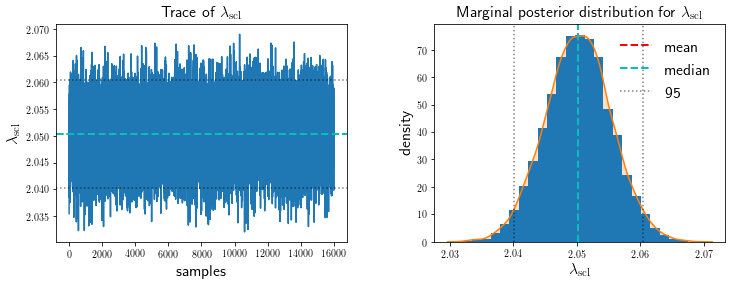

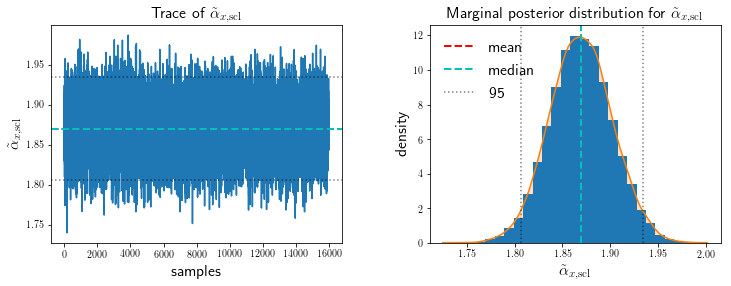

In [11]:
#Plot the individual traces of sampled parameters and their marginal distribution
def plot_trace(param, param_name='parameter'):  
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(param)
    plt.xlabel('samples',fontsize=16)
    plt.ylabel(param_name, fontsize=16)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.5)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.5)
    plt.title('Trace of {}'.format(param_name),fontsize=16)

    plt.subplot(1,2,2)
    plt.hist(param, 25, density=True); 
    sns.kdeplot(param, shade=True)
    plt.xlabel(param_name,fontsize=16)
    plt.ylabel('density',fontsize=16)
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.5, label='95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.5)
    plt.legend(fontsize=16, frameon=False)
    plt.title('Marginal posterior distribution for {}'.format(param_name),fontsize=16)
    fig.subplots_adjust(wspace=0.3)

#Examples:
plot_trace(trace['theta'][:,0], param_name=par_names[0])  
plot_trace(trace['theta'][:,2], param_name=par_names[2])  


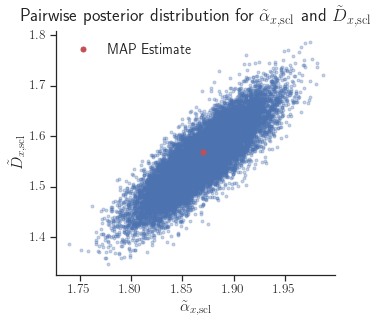

In [34]:
# plot pariwise posterior distribution for two parameters of choice
def pairwise(par1, par2, MAP_Estimate, param_names=['par1','par2']):
    sns.set()
    sns.set(font_scale=1.2)
    sns.set_style('ticks')
    plt.figure(figsize=(5,4.5))
    plt.plot(par1, par2, marker='.', linestyle='None', alpha=0.3)
    plt.plot(MAP_Estimate[0], MAP_Estimate[1], 'r.', markersize=10, label='MAP Estimate')
    plt.xlabel(param_names[0], fontsize=16)
    plt.ylabel(param_names[1], fontsize=16) 
    plt.title('Pairwise posterior distribution for {} and {}'.format(param_names[0],param_names[1]), fontsize=18)
    plt.legend(fontsize=14, frameon=False)
    sns.despine()
#Example:    
#choose parameters p1 and p2 
p1 = 2 
p2 = 5
pairwise(trace['theta'][:,p1], trace['theta'][:,p2], [MAP_pars[p1], MAP_pars[p2]], param_names=[par_names[p1], par_names[p2]])
